In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Loading and splitting data...
Found 2452 wav files.
Train samples: 1961, Test samples: 491
Augmenting train data...
Train samples after augmentation: 7844
Building DNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training DNN...
Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2230 - loss: 0.4818 - val_accuracy: 0.3783 - val_loss: 0.2680
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3447 - loss: 0.2831 - val_accuracy: 0.4662 - val_loss: 0.2151
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4474 - loss: 0.2190 - val_accuracy: 0.5299 - val_loss: 0.1833
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5260 - loss: 0.1879 - val_accuracy: 0.5618 - val_loss: 0.1678
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5769 - loss: 0.1619 - val_accuracy: 0.6153 - val_loss: 0.1453
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6112 - loss: 0.1435 - val_accuracy: 0.6153 - val_loss: 0.1340
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6484 - loss: 0.1233 - val_accuracy: 0.6153 - val_loss: 0.1334
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6730 - loss: 

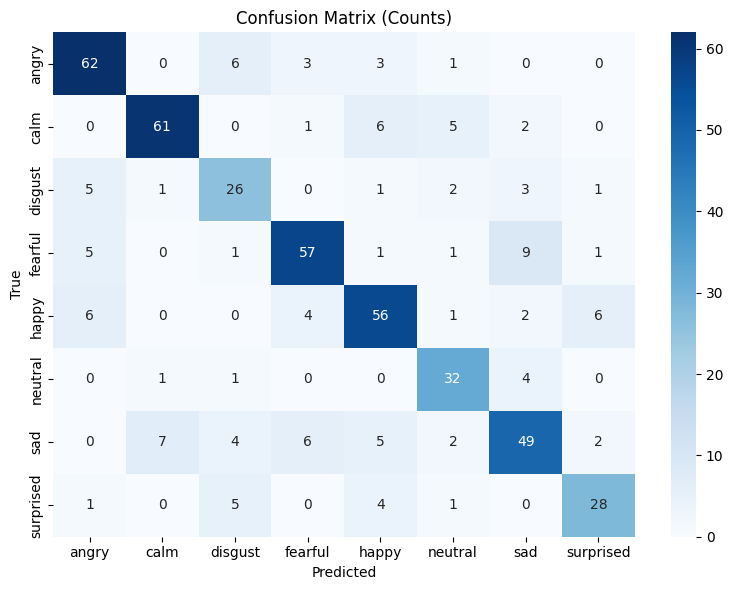

Pipeline complete. Models and scalers saved.


In [3]:
import os
import glob
import numpy as np
import librosa
import soundfile
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# ========== CONFIGURATION ==========
SONG_PATH = "/content/drive/MyDrive/Audio_Song_Actors_01-24"
SPEECH_PATH = "/content/drive/MyDrive/Audio_Speech_Actors_01-24"
SAMPLE_RATE = 16000
SEGMENT_DURATION = 2.0  # seconds
SEGMENT_OVERLAP = 0.5   # 50% overlap
AUG_PER_SAMPLE = 3     # number of augmentations per sample (train only)
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Update as per your dataset's emotion mapping
EMOTION_MAP = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
EMOTIONS = list(EMOTION_MAP.values())

# ========== DATA AUGMENTATION FUNCTIONS ==========
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def shift(data, sampling_rate, shift_max=0.2):
    shift = np.random.randint(sampling_rate * shift_max)
    direction = random.choice([-1, 1])
    return np.roll(data, direction * shift)

def stretch(data, rate=1.1):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sampling_rate, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

def volume_control(data, gain=1.25):
    return data * gain

def augment_audio(data, sampling_rate):
    aug_funcs = [
        lambda x: add_noise(x),
        lambda x: shift(x, sampling_rate),
        lambda x: stretch(x, rate=random.uniform(0.8, 1.2)),
        lambda x: pitch_shift(x, sampling_rate, n_steps=random.randint(-2, 2)),
        lambda x: volume_control(x, gain=random.uniform(0.8, 1.2))
    ]
    func = random.choice(aug_funcs)
    return func(data)

# ========== SEGMENT-BASED FEATURE EXTRACTION ==========
def extract_segment_features(y, sr):
    segment_length = int(SEGMENT_DURATION * sr)
    hop_length = int(segment_length * (1 - SEGMENT_OVERLAP))
    features = []
    for start in range(0, len(y) - segment_length + 1, hop_length):
        segment = y[start:start + segment_length]
        feats = []
        # MFCCs
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        feats.extend(np.mean(mfcc, axis=1))
        feats.extend(np.std(mfcc, axis=1))
        feats.extend(np.mean(mfcc_delta, axis=1))
        feats.extend(np.mean(mfcc_delta2, axis=1))
        # Chroma
        chroma = librosa.feature.chroma_stft(y=segment, sr=sr)
        feats.extend(np.mean(chroma, axis=1))
        # Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=segment, sr=sr)
        mel_db = librosa.power_to_db(mel)
        feats.extend(np.mean(mel_db, axis=1))
        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=segment, sr=sr)
        feats.extend(np.mean(contrast, axis=1))
        # Spectral Bandwidth
        bandwidth = librosa.feature.spectral_bandwidth(y=segment, sr=sr)
        feats.append(np.mean(bandwidth))
        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=segment, sr=sr)
        feats.append(np.mean(rolloff))
        # Spectral Flatness
        flatness = librosa.feature.spectral_flatness(y=segment)
        feats.append(np.mean(flatness))
        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(segment)
        feats.append(np.mean(zcr))
        # Root Mean Square Energy
        rmse = librosa.feature.rms(y=segment)
        feats.append(np.mean(rmse))
        features.append(feats)
    features = np.array(features)
    agg_features = []
    for stat in [np.mean, np.std, np.min, np.max]:
        agg_features.extend(stat(features, axis=0))
    return np.array(agg_features)

# ========== LOAD FILES AND LABELS ==========
def get_all_wav_files(root_dirs):
    wav_files = []
    for root_dir in root_dirs:
        for actor_folder in sorted(os.listdir(root_dir)):
            actor_path = os.path.join(root_dir, actor_folder)
            if not os.path.isdir(actor_path):
                continue
            wav_files.extend(glob.glob(os.path.join(actor_path, "*.wav")))
    return wav_files

def extract_emotion_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.split('-')
    if len(parts) < 3:
        return None
    emotion_code = parts[2]
    return EMOTION_MAP.get(emotion_code, None)

# ========== DATA SPLIT AND AUGMENTATION ==========
def load_and_split_data():
    X, y, files = [], [], []
    wav_files = get_all_wav_files([SONG_PATH, SPEECH_PATH])
    print(f"Found {len(wav_files)} wav files.")
    for file in wav_files:
        emotion = extract_emotion_from_filename(file)
        if emotion is None:
            continue
        try:
            y_raw, sr = librosa.load(file, sr=SAMPLE_RATE)
        except Exception:
            continue
        features = extract_segment_features(y_raw, sr)
        X.append(features)
        y.append(emotion)
        files.append(file)
    X, y, files = np.array(X), np.array(y), np.array(files)
    # Stratified split
    X_train, X_test, y_train, y_test, files_train, files_test = train_test_split(
        X, y, files, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    return X_train, X_test, y_train, y_test, files_train, files_test

def augment_train_data(X_train, y_train, files_train):
    X_aug, y_aug = [], []
    for i, file in enumerate(files_train):
        try:
            y_raw, sr = librosa.load(file, sr=SAMPLE_RATE)
        except Exception:
            continue
        for _ in range(AUG_PER_SAMPLE):
            y_augmented = augment_audio(y_raw, sr)
            feats_aug = extract_segment_features(y_augmented, sr)
            X_aug.append(feats_aug)
            y_aug.append(y_train[i])
    if X_aug:
        X_train = np.concatenate([X_train, np.array(X_aug)], axis=0)
        y_train = np.concatenate([y_train, np.array(y_aug)], axis=0)
    return X_train, y_train

# ========== FOCAL LOSS FOR KERAS ==========
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# ========== MAIN PIPELINE ==========
if __name__ == "__main__":
    print("Loading and splitting data...")
    X_train, X_test, y_train, y_test, files_train, files_test = load_and_split_data()
    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # Augment only train data
    print("Augmenting train data...")
    X_train, y_train = augment_train_data(X_train, y_train, files_train)
    print(f"Train samples after augmentation: {len(X_train)}")

    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    y_train_cat = to_categorical(y_train_enc)
    y_test_cat = to_categorical(y_test_enc)

    # Fit scaler and PCA only on train, apply to both
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    pca = PCA(n_components=0.98, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Compute class weights for imbalanced data
    class_weights = compute_class_weight(
        'balanced', classes=np.unique(y_train_enc), y=y_train_enc
    )
    class_weights_dict = {i: w for i, w in enumerate(class_weights)}

    # ========== ENSEMBLE: DNN + Random Forest ==========
    print("Building DNN...")
    dnn = Sequential([
        Dense(512, input_shape=(X_train_pca.shape[1],), activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(len(le.classes_), activation='softmax')
    ])
    dnn.compile(optimizer='adam',
                loss=focal_loss(gamma=2., alpha=.25),
                metrics=['accuracy'])

    print("Training DNN...")
    dnn.fit(X_train_pca, y_train_cat,
            epochs=100,
            batch_size=32,
            validation_split=0.1,
            class_weight=class_weights_dict,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
            verbose=1)

    print("Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=RANDOM_STATE)
    rf.fit(X_train_pca, np.argmax(y_train_cat, axis=1))

    # ========== ENSEMBLE PREDICTION ==========
    print("Evaluating ensemble...")
    y_pred_dnn = dnn.predict(X_test_pca)
    y_pred_rf = rf.predict_proba(X_test_pca)
    y_pred_ensemble = (y_pred_dnn + y_pred_rf) / 2
    y_pred_labels = np.argmax(y_pred_ensemble, axis=1)
    y_true_labels = np.argmax(y_test_cat, axis=1)

    # ========== REPORTS ==========
    print("Classification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_, digits=4))
    print("Confusion Matrix (absolute counts):")
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    print(cm)

    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    for idx, label in enumerate(le.classes_):
        print(f"Accuracy for class '{label}': {per_class_acc[idx]*100:.2f}% (Correct: {cm[idx, idx]}, Total: {cm.sum(axis=1)[idx]})")

    print("Overall Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
    print("F1 Score (macro):", f1_score(y_true_labels, y_pred_labels, average='macro'))
    print("Precision (per class):", precision_score(y_true_labels, y_pred_labels, average=None))

    # Confusion matrix plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Counts)')
    plt.tight_layout()
    plt.savefig("confusion_matrix_counts.png")
    plt.show()

    # ========== SAVE MODELS & SCALERS ==========
    dnn.save("ser_dnn_model.h5")
    with open("rf_model.pkl", "wb") as f:
        pickle.dump(rf, f)
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
    with open("pca.pkl", "wb") as f:
        pickle.dump(pca, f)
    with open("label_encoder.pkl", "wb") as f:
        pickle.dump(le, f)

    print("Pipeline complete. Models and scalers saved.")
